In this notebook, we use `SequenceClassification` class provided by Transformers. It's a Transformer model with a linear layer on top, so each excerpt is represented by an embedding which is fed into the linear layer to produce the score. Three Transformers models are used: BERT (uncased), RoBERTa, and DistilBERT (uncased).

In [ ]:
!pip install transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AdamW,
                          get_linear_schedule_with_warmup, set_seed)

In [ ]:
train_data = pd.read_csv('train.csv')  # 2834 rows, 6 cols
test_data  = pd.read_csv('test.csv')   #    7 rows, 4 cols

In [ ]:
model_path_dict = {
    'bert'   : 'bert-base-uncased',
    'roberta': 'roberta-base',
    'distil' : 'distilbert-base-uncased'
}
n_epoch = 20
n_folds = 3
seq_len = 256
batch_size = 32

set_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

cuda is used


In [ ]:
class loader(Dataset):
    def __init__(self, tokens, labels=None):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokens.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        if self.labels is not None:
            return len(self.labels)
        return len(self.tokens['input_ids'])

In [ ]:
def train(model, optimizer, scheduler, train_loader, device):
    total_train_loss = 0
    model.train() # put to train mode
    for batch in train_loader:
        print(".", end="", flush=True)
        optimizer.zero_grad()
        outputs = model(batch['input_ids'].to(device),
                        attention_mask=batch['attention_mask'].to(device),
                        labels=batch['labels'].to(device))
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step() # update learning rate
    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

In [ ]:
def evaluate(model, val_loader, device):
    total_val_loss = 0
    model.eval() # put to eval mode
    for step, batch in enumerate(val_loader):
        with torch.no_grad():
            outputs = model(batch['input_ids'].to(device),
                            attention_mask=batch['attention_mask'].to(device),
                            labels=batch['labels'].to(device))   
            total_val_loss += outputs[0].item()
    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

In [ ]:
def predict(model, test_loader, device):
    y_preds = []
    for batch in test_loader:
        with torch.no_grad():
            outputs = model(batch['input_ids'].to(device),
                            attention_mask=batch['attention_mask'].to(device))   
            preds = outputs[0].detach().cpu().numpy()
            y_preds.append(preds)
    return np.concatenate(y_preds).ravel()

Train the 3 models with k-fold cross validation (k = 3) to see the performance.

In [ ]:
all_loss = {}

for model_name, model_path in model_path_dict.items():
    print('\n' + model_name)

    skf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    model_loss = np.zeros((n_folds, n_epoch, 2))

    for fold, (idxT, idxV) in enumerate(skf.split(train_data)):
        print("Fold:", fold)

        # Tokenize data
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        train_tokens = tokenizer.batch_encode_plus(train_data['excerpt'][idxT].tolist(),
                                                   max_length=seq_len, padding='longest', truncation=True)
        val_tokens = tokenizer.batch_encode_plus(train_data['excerpt'][idxV].tolist(),
                                                 max_length=seq_len, padding='longest', truncation=True)

        # Create data loader
        train_loader = DataLoader(loader(train_tokens, train_data['target'][idxT].values),
                                  batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(loader(val_tokens, train_data['target'][idxV].values),
                                batch_size=batch_size, shuffle=True)

        # Build model
        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=5e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                                    num_training_steps = len(train_loader) * n_epoch)

        # Train model
        for epoch in range(n_epoch):
            avg_train_loss = train(model, optimizer, scheduler, train_loader, device)
            avg_val_loss = evaluate(model, val_loader, device)

            model_loss[fold][epoch][0] = avg_train_loss
            model_loss[fold][epoch][1] = avg_val_loss
            print("\ntrain_loss: %.5f - val_loss: %.5f"%(avg_train_loss, avg_val_loss))
  
    all_loss[model_name] = model_loss


bert
Fold: 0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

............................................................
train_loss: 0.54305 - val_loss: 0.35174
............................................................
train_loss: 0.22929 - val_loss: 0.40365
............................................................
train_loss: 0.12348 - val_loss: 0.27598
............................................................
train_loss: 0.07585 - val_loss: 0.55073
............................................................
train_loss: 0.05766 - val_loss: 0.29998
............................................................
train_loss: 0.04215 - val_loss: 0.34539
............................................................
train_loss: 0.03226 - val_loss: 0.29580
............................................................
train_loss: 0.02999 - val_loss: 0.56458
............................................................
train_loss: 0.03602 - val_loss: 0.44495
............................................................
train_loss: 0.03115 - val_loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

............................................................
train_loss: 0.58771 - val_loss: 0.47701
............................................................
train_loss: 0.25110 - val_loss: 0.67559
............................................................
train_loss: 0.16741 - val_loss: 0.31752
............................................................
train_loss: 0.09144 - val_loss: 0.33459
............................................................
train_loss: 0.06783 - val_loss: 0.55680
............................................................
train_loss: 0.05298 - val_loss: 0.27311
............................................................
train_loss: 0.03572 - val_loss: 0.43075
............................................................
train_loss: 0.03549 - val_loss: 0.28461
............................................................
train_loss: 0.03255 - val_loss: 0.33458
............................................................
train_loss: 0.02401 - val_loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

............................................................
train_loss: 0.68641 - val_loss: 0.65892
............................................................
train_loss: 0.30658 - val_loss: 0.34420
............................................................
train_loss: 0.15908 - val_loss: 0.73500
............................................................
train_loss: 0.11009 - val_loss: 0.35725
............................................................
train_loss: 0.06026 - val_loss: 0.31914
............................................................
train_loss: 0.05338 - val_loss: 0.40079
............................................................
train_loss: 0.03785 - val_loss: 0.29846
............................................................
train_loss: 0.03064 - val_loss: 0.32452
............................................................
train_loss: 0.02084 - val_loss: 0.38029
............................................................
train_loss: 0.01795 - val_loss

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

............................................................
train_loss: 0.85779 - val_loss: 0.41169
............................................................
train_loss: 0.38803 - val_loss: 0.31694
............................................................
train_loss: 0.22944 - val_loss: 0.27270
............................................................
train_loss: 0.15903 - val_loss: 0.35480
............................................................
train_loss: 0.09992 - val_loss: 0.38964
............................................................
train_loss: 0.06565 - val_loss: 0.75868
............................................................
train_loss: 0.06619 - val_loss: 0.26609
............................................................
train_loss: 0.05150 - val_loss: 0.52807
............................................................
train_loss: 0.03846 - val_loss: 0.38142
............................................................
train_loss: 0.02987 - val_loss

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

............................................................
train_loss: 0.72094 - val_loss: 0.56954
............................................................
train_loss: 0.36025 - val_loss: 0.32057
............................................................
train_loss: 0.24117 - val_loss: 0.27743
............................................................
train_loss: 0.14911 - val_loss: 0.26063
............................................................
train_loss: 0.12227 - val_loss: 0.27015
............................................................
train_loss: 0.07386 - val_loss: 0.32544
............................................................
train_loss: 0.05365 - val_loss: 0.31823
............................................................
train_loss: 0.04438 - val_loss: 0.35305
............................................................
train_loss: 0.03689 - val_loss: 0.42717
............................................................
train_loss: 0.03441 - val_loss

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

............................................................
train_loss: 0.65408 - val_loss: 0.34068
............................................................
train_loss: 0.31287 - val_loss: 0.50750
............................................................
train_loss: 0.23804 - val_loss: 0.33812
............................................................
train_loss: 0.12867 - val_loss: 0.26395
............................................................
train_loss: 0.09471 - val_loss: 0.41238
............................................................
train_loss: 0.08477 - val_loss: 0.34833
............................................................
train_loss: 0.05647 - val_loss: 0.30752
............................................................
train_loss: 0.04257 - val_loss: 0.36811
............................................................
train_loss: 0.03784 - val_loss: 0.37335
............................................................
train_loss: 0.03410 - val_loss

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

............................................................
train_loss: 0.56297 - val_loss: 0.37794
............................................................
train_loss: 0.24577 - val_loss: 0.33441
............................................................
train_loss: 0.15708 - val_loss: 0.41711
............................................................
train_loss: 0.10140 - val_loss: 0.44238
............................................................
train_loss: 0.06358 - val_loss: 0.32639
............................................................
train_loss: 0.03855 - val_loss: 0.37342
............................................................
train_loss: 0.02650 - val_loss: 0.31966
............................................................
train_loss: 0.02652 - val_loss: 0.30446
............................................................
train_loss: 0.03977 - val_loss: 0.28598
............................................................
train_loss: 0.02970 - val_loss

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

............................................................
train_loss: 0.56451 - val_loss: 0.32213
............................................................
train_loss: 0.25035 - val_loss: 0.39875
............................................................
train_loss: 0.14953 - val_loss: 0.31879
............................................................
train_loss: 0.10121 - val_loss: 0.35573
............................................................
train_loss: 0.05938 - val_loss: 0.38322
............................................................
train_loss: 0.07917 - val_loss: 0.28521
............................................................
train_loss: 0.03652 - val_loss: 0.32745
............................................................
train_loss: 0.02835 - val_loss: 0.28746
............................................................
train_loss: 0.02856 - val_loss: 0.32283
............................................................
train_loss: 0.02096 - val_loss

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

............................................................
train_loss: 0.56566 - val_loss: 0.35970
............................................................
train_loss: 0.27018 - val_loss: 0.30761
............................................................
train_loss: 0.16093 - val_loss: 0.29482
............................................................
train_loss: 0.09955 - val_loss: 0.32066
............................................................
train_loss: 0.06388 - val_loss: 0.31244
............................................................
train_loss: 0.04183 - val_loss: 0.28135
............................................................
train_loss: 0.03706 - val_loss: 0.27388
............................................................
train_loss: 0.03776 - val_loss: 0.32729
............................................................
train_loss: 0.02543 - val_loss: 0.29310
............................................................
train_loss: 0.02412 - val_loss

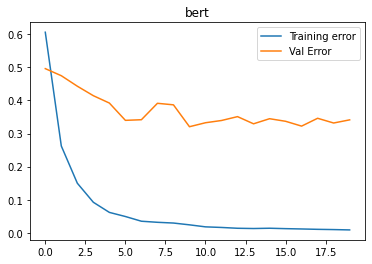

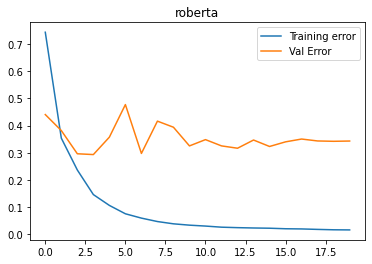

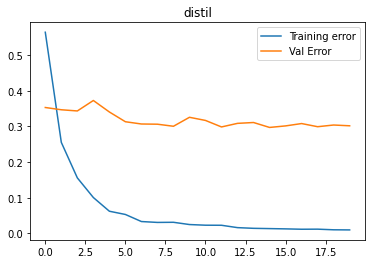

In [ ]:
# Plot the learning curve
# The loss per epoch is the average of all folds
for model_name, model_loss in all_loss.items():
    plt.figure()
    plt.title(model_name)
    plt.plot(np.mean(all_loss[model_name][:,:,0], axis=0), label='Training error')
    plt.plot(np.mean(all_loss[model_name][:,:,1], axis=0), label='Val Error')
    plt.legend()

Train the 3 models with full dataset to make prediction on the blind test set. 

In [ ]:
all_submissions = {}
n_epoch = 10

for model_name, model_path in model_path_dict.items():
    print('\n' + model_name)

    # Tokenize data
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    train_tokens = tokenizer.batch_encode_plus(train_data['excerpt'].tolist(),
                                               max_length=seq_len, padding='longest', truncation=True)
    test_tokens = tokenizer.batch_encode_plus(test_data['excerpt'].tolist(),
                                              max_length=seq_len, padding='longest', truncation=True)

    # Create data loader
    train_loader = DataLoader(loader(train_tokens, train_data['target'].values),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(loader(test_tokens), batch_size=batch_size, shuffle=True)

    # Build model
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                                num_training_steps = len(train_loader) * n_epoch)

    # Train model
    for epoch in range(n_epoch):
        avg_train_loss = train(model, optimizer, scheduler, train_loader, device)
    
    # Predict blind test set
    test_data['target'] = predict(model, test_loader, device)
    all_submissions[model_name] = test_data[['id', 'target']]

The final submission is the average of the predictions made by the 3 models.

In [ ]:
target = None
for submission in all_submissions.values():
    if target is None:
        target = submission['target'].values.copy()
    else:
        target += submission['target'].values
target/=len(all_submissions)
test_data['target'] = target
submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)